# Imports

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit import *
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

from numpy import pi
import qiskit.quantum_info as qi

# Tomography Functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc


ibmqfactory.load_account:WARNING:2021-08-15 12:54:35,342: Credentials are already in use. The existing account in the session will be replaced.


# Create Circuit

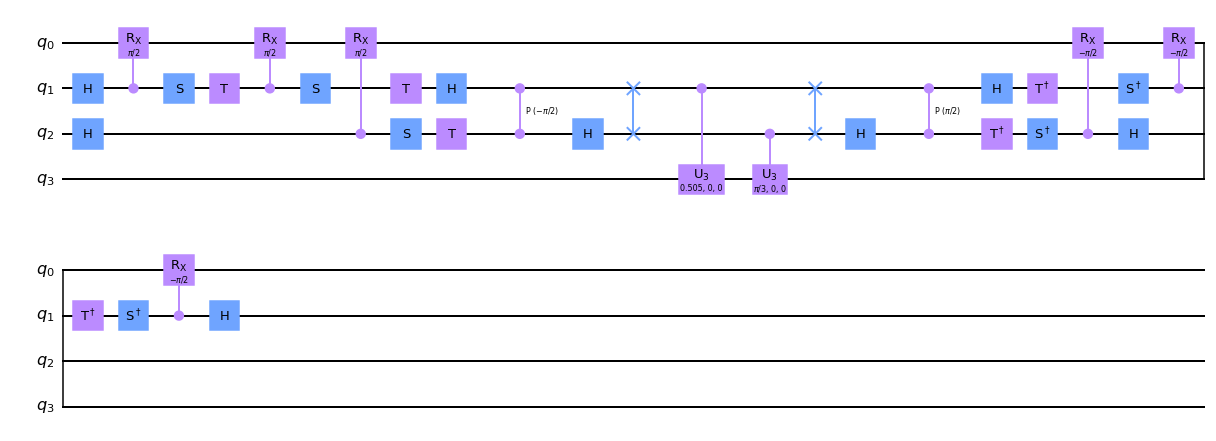

In [101]:
qreg_q = QuantumRegister(4, 'q')
circuit = QuantumCircuit(qreg_q)

# circuit.barrier(qreg_q[0])

# Quantum Phase Estimation
circuit.h(qreg_q[1])
circuit.h(qreg_q[2])

# CU^2
circuit.crx(pi/2, qreg_q[1], qreg_q[0])
circuit.s(qreg_q[1])
circuit.t(qreg_q[1])
circuit.crx(pi/2, qreg_q[1], qreg_q[0])
circuit.s(qreg_q[1])
circuit.t(qreg_q[1])

# CU
circuit.crx(pi/2, qreg_q[2], qreg_q[0])
circuit.s(qreg_q[2])
circuit.t(qreg_q[2])
# circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])

# QFT Inverse
circuit.h(qreg_q[1])
circuit.cp(-pi/2, qreg_q[1], qreg_q[2])
circuit.h(qreg_q[2])
circuit.swap(qreg_q[1], qreg_q[2])

# Rotation of the ancilla
theta1 = 2*np.arccos(np.sqrt(3)/2)
theta2 = 2*np.arccos(np.sqrt(15)/4)
circuit.cu3(theta2, 0, 0, qreg_q[1], qreg_q[3])
circuit.cu3(theta1, 0, 0, qreg_q[2], qreg_q[3])

# QPE Inverse

# QFT 
circuit.swap(qreg_q[1], qreg_q[2])
circuit.h(qreg_q[2])
circuit.cp(pi/2, qreg_q[1], qreg_q[2])
circuit.h(qreg_q[1])

# circuit.barrier()
# CU Inverse
# circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
circuit.tdg(qreg_q[2])
circuit.sdg(qreg_q[2])
circuit.crx(-pi/2, qreg_q[2], qreg_q[0])

# CU^2 Inverse
circuit.tdg(qreg_q[1])
circuit.sdg(qreg_q[1])
circuit.crx(-pi/2, qreg_q[1], qreg_q[0])
circuit.tdg(qreg_q[1])
circuit.sdg(qreg_q[1])
circuit.crx(-pi/2, qreg_q[1], qreg_q[0])
# circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

# Superposition Inverse
circuit.h(qreg_q[1])
circuit.h(qreg_q[2])
# circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

qc = circuit
qr = qreg_q
qc.draw('mpl')


# Setup for conditional tomography of first qubit, conditioned on Ancilla Giving 1

In [102]:
qst = state_tomography_circuits(qc,[qr[0]])
qst_no_anc = deepcopy(qst)
ca = ClassicalRegister(1)
for qst_circ in qst:
    qst_circ.add_register(ca)
    qst_circ.measure(qr[3],ca[0])

## Run on Simulator

In [103]:
#Run in Aer
job = qiskit.execute(qst, Aer.get_backend('qasm_simulator'), shots=50000)
raw_results = job.result()

In [104]:
new_result = deepcopy(raw_results)
# Keep only results where ancilla gave 1
for resultidx, _ in enumerate(raw_results.results):
    old_counts = raw_results.get_counts(resultidx)
    new_counts = {}
    
    #change the size of the classical register
    new_result.results[resultidx].header.creg_sizes = [new_result.results[resultidx].header.creg_sizes[0]]
    new_result.results[resultidx].header.clbit_labels = new_result.results[resultidx].header.clbit_labels[0:-1]
    new_result.results[resultidx].header.memory_slots = 1
    
    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        if reg_bits[0]=='1':
            new_counts[reg_bits[1]]=old_counts[reg_key]

        new_result.results[resultidx].data.counts = new_counts 

In [105]:
tomo = StateTomographyFitter(new_result, qst_no_anc)
# Perform the tomography fit
# which outputs a density matrix
rho_fit = tomo.fit(method='lstsq')

In [106]:
print(rho_fit)
print((rho_fit[0][0]**(0.5))/(3/np.sqrt(10)))
print((rho_fit[1][1]**(0.5))/(1/np.sqrt(10)))

[[0.89994902+0.j         0.29439611+0.00575006j]
 [0.29439611-0.00575006j 0.10005098+0.j        ]]
(0.9999716766034525+0j)
(1.0002548744784607+0j)


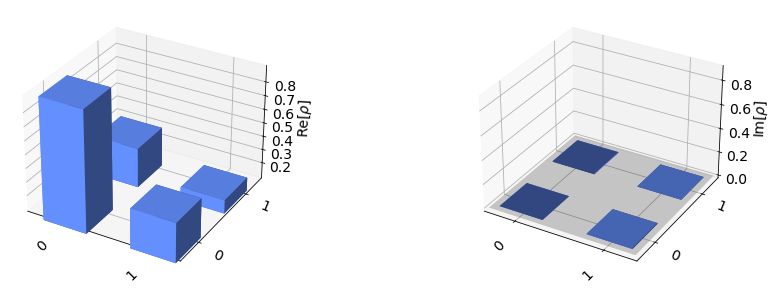

In [107]:
plot_state_city(rho_fit)

## Run on Quantum Computer

ibmq_bogota


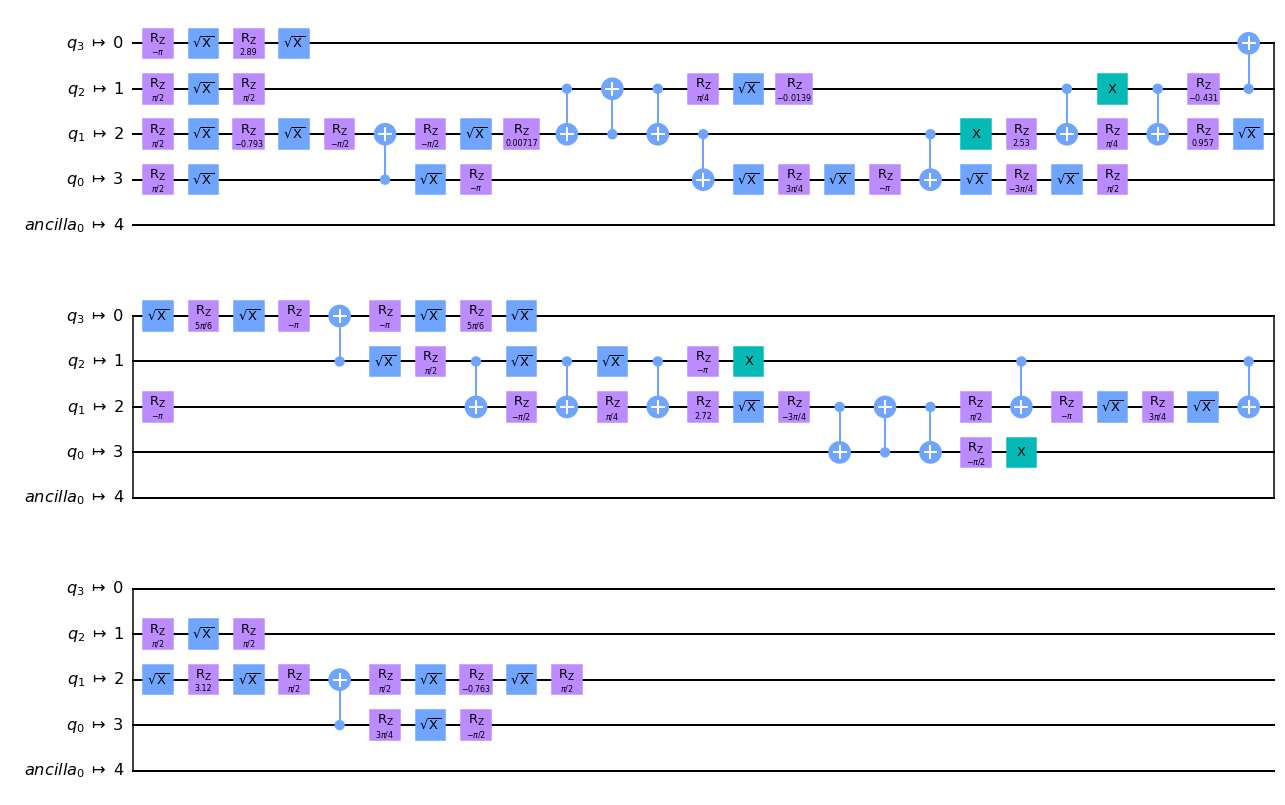

In [118]:
backend = provider.backends('ibmq_bogota')[0]
print(backend)
t_qc = transpile(qc, backend, optimization_level=3)
t_qc.draw('mpl')

In [119]:
#generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0])

job_cal = qiskit.execute(meas_calibs, backend=backend, shots=8192)
job_tomo = qiskit.execute(qst, backend=backend, shots=8192, optimization_level = 3)
raw_results = job_tomo.result()
new_result = deepcopy(raw_results)

for resultidx, _ in enumerate(raw_results.results):
    old_counts = raw_results.get_counts(resultidx)
    new_counts = {}
    
    #change the size of the classical register
    new_result.results[resultidx].header.creg_sizes = [new_result.results[resultidx].header.creg_sizes[0]]
    new_result.results[resultidx].header.clbit_labels = new_result.results[resultidx].header.clbit_labels[0:-1]
    new_result.results[resultidx].header.memory_slots = 1
    
    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        if reg_bits[0]=='1':
            new_counts[reg_bits[1]]=old_counts[reg_key]

        new_result.results[resultidx].data.counts = new_counts 

meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

In [120]:
correct_tomo_results = meas_fitter.filter.apply(new_result, method='least_squares')
tomo_mit = StateTomographyFitter(correct_tomo_results, qst_no_anc)
rho_fit = tomo_mit.fit(method='lstsq')

In [121]:
print(rho_fit)
print((rho_fit[0][0]**(0.5))/(3/np.sqrt(10)))
print((rho_fit[1][1]**(0.5))/(1/np.sqrt(10)))

[[0.62407471+0.j         0.02964504+0.02790056j]
 [0.02964504-0.02790056j 0.37592529+0.j        ]]
(0.8327162422891561+0j)
(1.9388792996085258+0j)


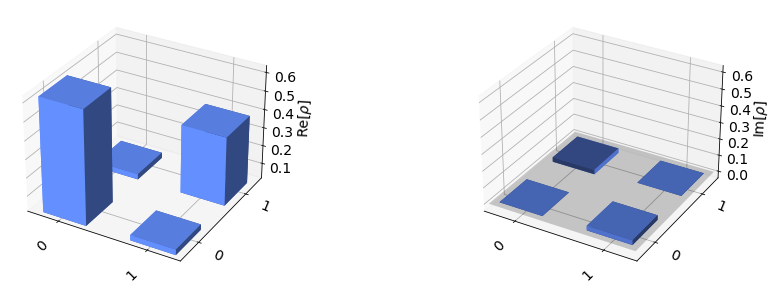

In [122]:
plot_state_city(rho_fit)